In [195]:
# Core Python Libraries
import os  # Operating system interactions, such as reading and writing files.
import shutil  # High-level file operations like copying and moving files.
import random  # Random number generation for various tasks.
import textwrap  # Formatting text into paragraphs of a specified width.
import warnings  # Warning control context manager.
import zipfile  # Work with ZIP archives.
import platform  # Access to underlying platform’s identifying data.
from dataclasses import dataclass  # Class decorator for adding special methods to classes.


# PyTorch-related Libraries (Deep Learning)
import torch  # Core PyTorch library for tensor computations.
import torch.nn as nn  # Neural network module for defining layers and architectures.
import torch.optim as optim  # Optimizer module for training models (SGD, Adam, etc.).
from torch.utils.data import Dataset, DataLoader  # Dataset and DataLoader for managing and batching data.
import torchvision # PyTorch's computer vision library.
import torchvision.transforms as transforms  # Transformations for image preprocessing.
from torchvision.utils import make_grid  # Make grid for displaying images.
from torchsummary import summary  # PyTorch model summary for Keras-like model summary.
from torchvision.ops import sigmoid_focal_loss  # Focal loss for handling class imbalance in object detection.
from torchmetrics import MeanMetric  # Intersection over Union (IoU) metric for object detection.
from torchmetrics.classification import MultilabelF1Score, MultilabelRecall, MultilabelPrecision, MultilabelAccuracy  # Multilabel classification metrics.

import lightning.pytorch as pl
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

# Geospatial Data Processing Libraries
import rasterio  # Library for reading and writing geospatial raster data.
from rasterio.warp import calculate_default_transform, reproject  # Reprojection and transformation functions.
from rasterio.enums import Resampling  # Resampling methods used for resizing raster data.
from rasterio.plot import show  # Visualization of raster data.

# Data Manipulation and Analysis Libraries
import pandas as pd  # Data analysis and manipulation library for DataFrames and CSVs.
import numpy as np  # Numpy for array operations and numerical computations.

# Visualization Libraries
import matplotlib.pyplot as plt  # Plotting library for creating static and interactive visualizations.
import seaborn as sns  # High-level interface for drawing attractive statistical graphics.

# Utilities
from tqdm import tqdm  # Progress bar for loops and processes.
from PIL import Image  # Image handling, opening, manipulating, and saving.
import ast  # Abstract Syntax Trees for parsing Python code.
import requests  # HTTP library for sending requests.
import zstandard as zstd  # Zstandard compression for fast compression and decompression.
from collections import Counter # Counter for counting hashable objects.


In [196]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

torch.set_float32_matmul_precision('medium')
warnings.filterwarnings(action="ignore", category=UserWarning)
sns.set_palette(sns.color_palette("rocket_r"))
%matplotlib inline

In [197]:
# Load the metadata
metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata.parquet')
subset_metadata_df = pd.read_parquet(r'C:\Users\isaac\Desktop\BigEarthTests\one_percent_metadata.parquet')
# Load the metadata for the snow/cloud/shadow data
#snow_cloud_shadow_metadata_df = pd.read_parquet(r'C:\Users\isaac\Downloads\metadata_for_patches_with_snow_cloud_or_shadow.parquet')

#metadata_csv = pd.read_csv(r'C:\Users\isaac\Desktop\BigEarthTests\one_percent_metadata.csv')

# Base directories
source_dir = r'C:\Users\isaac\Desktop\BigEarthTests\OnePBigEarthNet'

In [198]:
# Data class for dataset configuration
@dataclass
class DatasetConfig:
    image_size: tuple = (120, 120)
    channels: int = 3
    num_classes: int = 19

    mean: tuple = (0.485, 0.456, 0.406)
    std: tuple = (0.229, 0.224, 0.225)

    COMMON_IMG_DIR = r'C:\Users\isaac\Desktop\BigEarthTests\OnePBigEarthNet'
    SUBSET_METADATA_DF = pd.read_parquet(r'C:\Users\isaac\Desktop\BigEarthTests\one_percent_metadata.parquet')

# Data class for model configuration
@dataclass
class ModelConfig:
    batch_size: int = 32
    num_epochs: int = 10
    learning_rate: float = 0.0001
    num_workers: int = 0 if platform.system() == 'Windows' else os.cpu_count()
    optimizer: str = 'adam'
    model_name: str = 'resnet18'
    freeze_backbone: bool = False



In [199]:
# Ensure that the labels column contains lists
subset_metadata_df['labels'] = subset_metadata_df['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the lists of labels and extract unique labels
unique_labels = subset_metadata_df['labels'].explode().explode().unique()

# Create a dictionary mapping indices to labels
labels = {i: label for i, label in enumerate(unique_labels)}
print(labels)

# Reverse the labels dictionary
reversed_labels = {label: i for i, label in labels.items()}
print(reversed_labels)

{0: 'Arable land', 1: 'Broad-leaved forest', 2: 'Land principally occupied by agriculture, with significant areas of natural vegetation', 3: 'Pastures', 4: 'Urban fabric', 5: 'Complex cultivation patterns', 6: 'Coniferous forest', 7: 'Inland waters', 8: 'Mixed forest', 9: 'Industrial or commercial units', 10: 'Inland wetlands', 11: 'Transitional woodland, shrub', 12: 'Natural grassland and sparsely vegetated areas', 13: 'Marine waters', 14: 'Moors, heathland and sclerophyllous vegetation', 15: 'Permanent crops', 16: 'Agro-forestry areas', 17: 'Beaches, dunes, sands', 18: 'Coastal wetlands'}
{'Arable land': 0, 'Broad-leaved forest': 1, 'Land principally occupied by agriculture, with significant areas of natural vegetation': 2, 'Pastures': 3, 'Urban fabric': 4, 'Complex cultivation patterns': 5, 'Coniferous forest': 6, 'Inland waters': 7, 'Mixed forest': 8, 'Industrial or commercial units': 9, 'Inland wetlands': 10, 'Transitional woodland, shrub': 11, 'Natural grassland and sparsely vege

In [200]:
# List to store the counts and patch_ids
label_counts = []

# Iterate through each unique label and count the number of images with only that label
for label in unique_labels:
    # Filter the DataFrame to get rows with only the current label
    filtered_df = subset_metadata_df[subset_metadata_df['labels'].apply(lambda x: x == [label])]
    # Get the count of such rows
    count = filtered_df.shape[0]
    # Get the list of patch_ids
    patch_ids = filtered_df['patch_id'].tolist()
    # Append the label, count, and patch_ids to the list
    label_counts.append((label, count, patch_ids))

# Sort the list of tuples by the count in ascending order
label_counts.sort(key=lambda x: x[1])
# Dictionary to store a random patch_id for each label
random_patch_ids = {}

# List to store the directory paths
directory_paths = []

# Print the sorted counts and patch_ids, and save a random patch_id for each label
for label, count, patch_ids in label_counts:
    if count > 0:
        # Select a random patch_id from the list
        random_patch_id = random.choice(patch_ids)
    else:
        # Select a random patch_id that includes the label as part of its labels
        filtered_df = subset_metadata_df[subset_metadata_df['labels'].apply(lambda x: label in x and len(x) <= 2)]
        if not filtered_df.empty:
            random_patch_id = random.choice(filtered_df['patch_id'].tolist())
        else:
            random_patch_id = None  # Handle case where no patch_id includes the label
    
    if random_patch_id:
        random_patch_ids[label] = random_patch_id

# Print the random patch_ids for each label
print("Random patch IDs for each label:")
for i, (label, patch_id) in enumerate(random_patch_ids.items(), start=1):
    print(f"{i}. Label: {label}, Random Patch ID: {patch_id}")

    # Extract the base patch_id without the last _(num)_(num)
    base_patch_id = '_'.join(patch_id.split('_')[:-2])
    
    # Define the directory path with .tif extension
    dir_path = os.path.join(r'C:\Users\isaac\Desktop\BigEarthTests\OnePBigEarthNet', base_patch_id, patch_id)
    
    # Save the directory path
    directory_paths.append(dir_path)
    
# Optionally, save the directory paths to a file
with open(r'C:\Users\isaac\Desktop\BigEarthTests\directory_paths.txt', 'w') as f:
    for path in directory_paths:
        f.write(f"{path}\n")


Random patch IDs for each label:
1. Label: Industrial or commercial units, Random Patch ID: S2A_MSIL2A_20171015T095031_N9999_R079_T33UXP_00_35
2. Label: Natural grassland and sparsely vegetated areas, Random Patch ID: S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_56_18
3. Label: Beaches, dunes, sands, Random Patch ID: S2B_MSIL2A_20171112T114339_N9999_R123_T29UPU_80_34
4. Label: Coastal wetlands, Random Patch ID: S2A_MSIL2A_20171002T112111_N9999_R037_T29SNB_76_86
5. Label: Land principally occupied by agriculture, with significant areas of natural vegetation, Random Patch ID: S2B_MSIL2A_20180502T093039_N9999_R136_T34TEP_83_11
6. Label: Complex cultivation patterns, Random Patch ID: S2A_MSIL2A_20170818T103021_N9999_R108_T32TMT_56_62
7. Label: Inland wetlands, Random Patch ID: S2A_MSIL2A_20180529T115401_N9999_R023_T29UNB_35_88
8. Label: Urban fabric, Random Patch ID: S2B_MSIL2A_20170927T094019_N9999_R036_T35ULB_48_62
9. Label: Moors, heathland and sclerophyllous vegetation, Random Patch ID

{'S2A_MSIL2A_20171015T095031_N9999_R079_T33UXP_00_35': 'Industrial or commercial units', 'S2A_MSIL2A_20170617T113321_N9999_R080_T29UPU_56_18': 'Natural grassland and sparsely vegetated areas', 'S2B_MSIL2A_20171112T114339_N9999_R123_T29UPU_80_34': 'Beaches, dunes, sands', 'S2A_MSIL2A_20171002T112111_N9999_R037_T29SNB_76_86': 'Coastal wetlands', 'S2B_MSIL2A_20180502T093039_N9999_R136_T34TEP_83_11': 'Land principally occupied by agriculture, with significant areas of natural vegetation', 'S2A_MSIL2A_20170818T103021_N9999_R108_T32TMT_56_62': 'Complex cultivation patterns', 'S2A_MSIL2A_20180529T115401_N9999_R023_T29UNB_35_88': 'Inland wetlands', 'S2B_MSIL2A_20170927T094019_N9999_R036_T35ULB_48_62': 'Urban fabric', 'S2A_MSIL2A_20170704T112111_N9999_R037_T29SND_27_18': 'Moors, heathland and sclerophyllous vegetation', 'S2B_MSIL2A_20180428T095029_N9999_R079_T33TXN_07_38': 'Mixed forest', 'S2B_MSIL2A_20180224T112109_N9999_R037_T29SNC_17_56': 'Transitional woodland, shrub', 'S2A_MSIL2A_20170813T

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

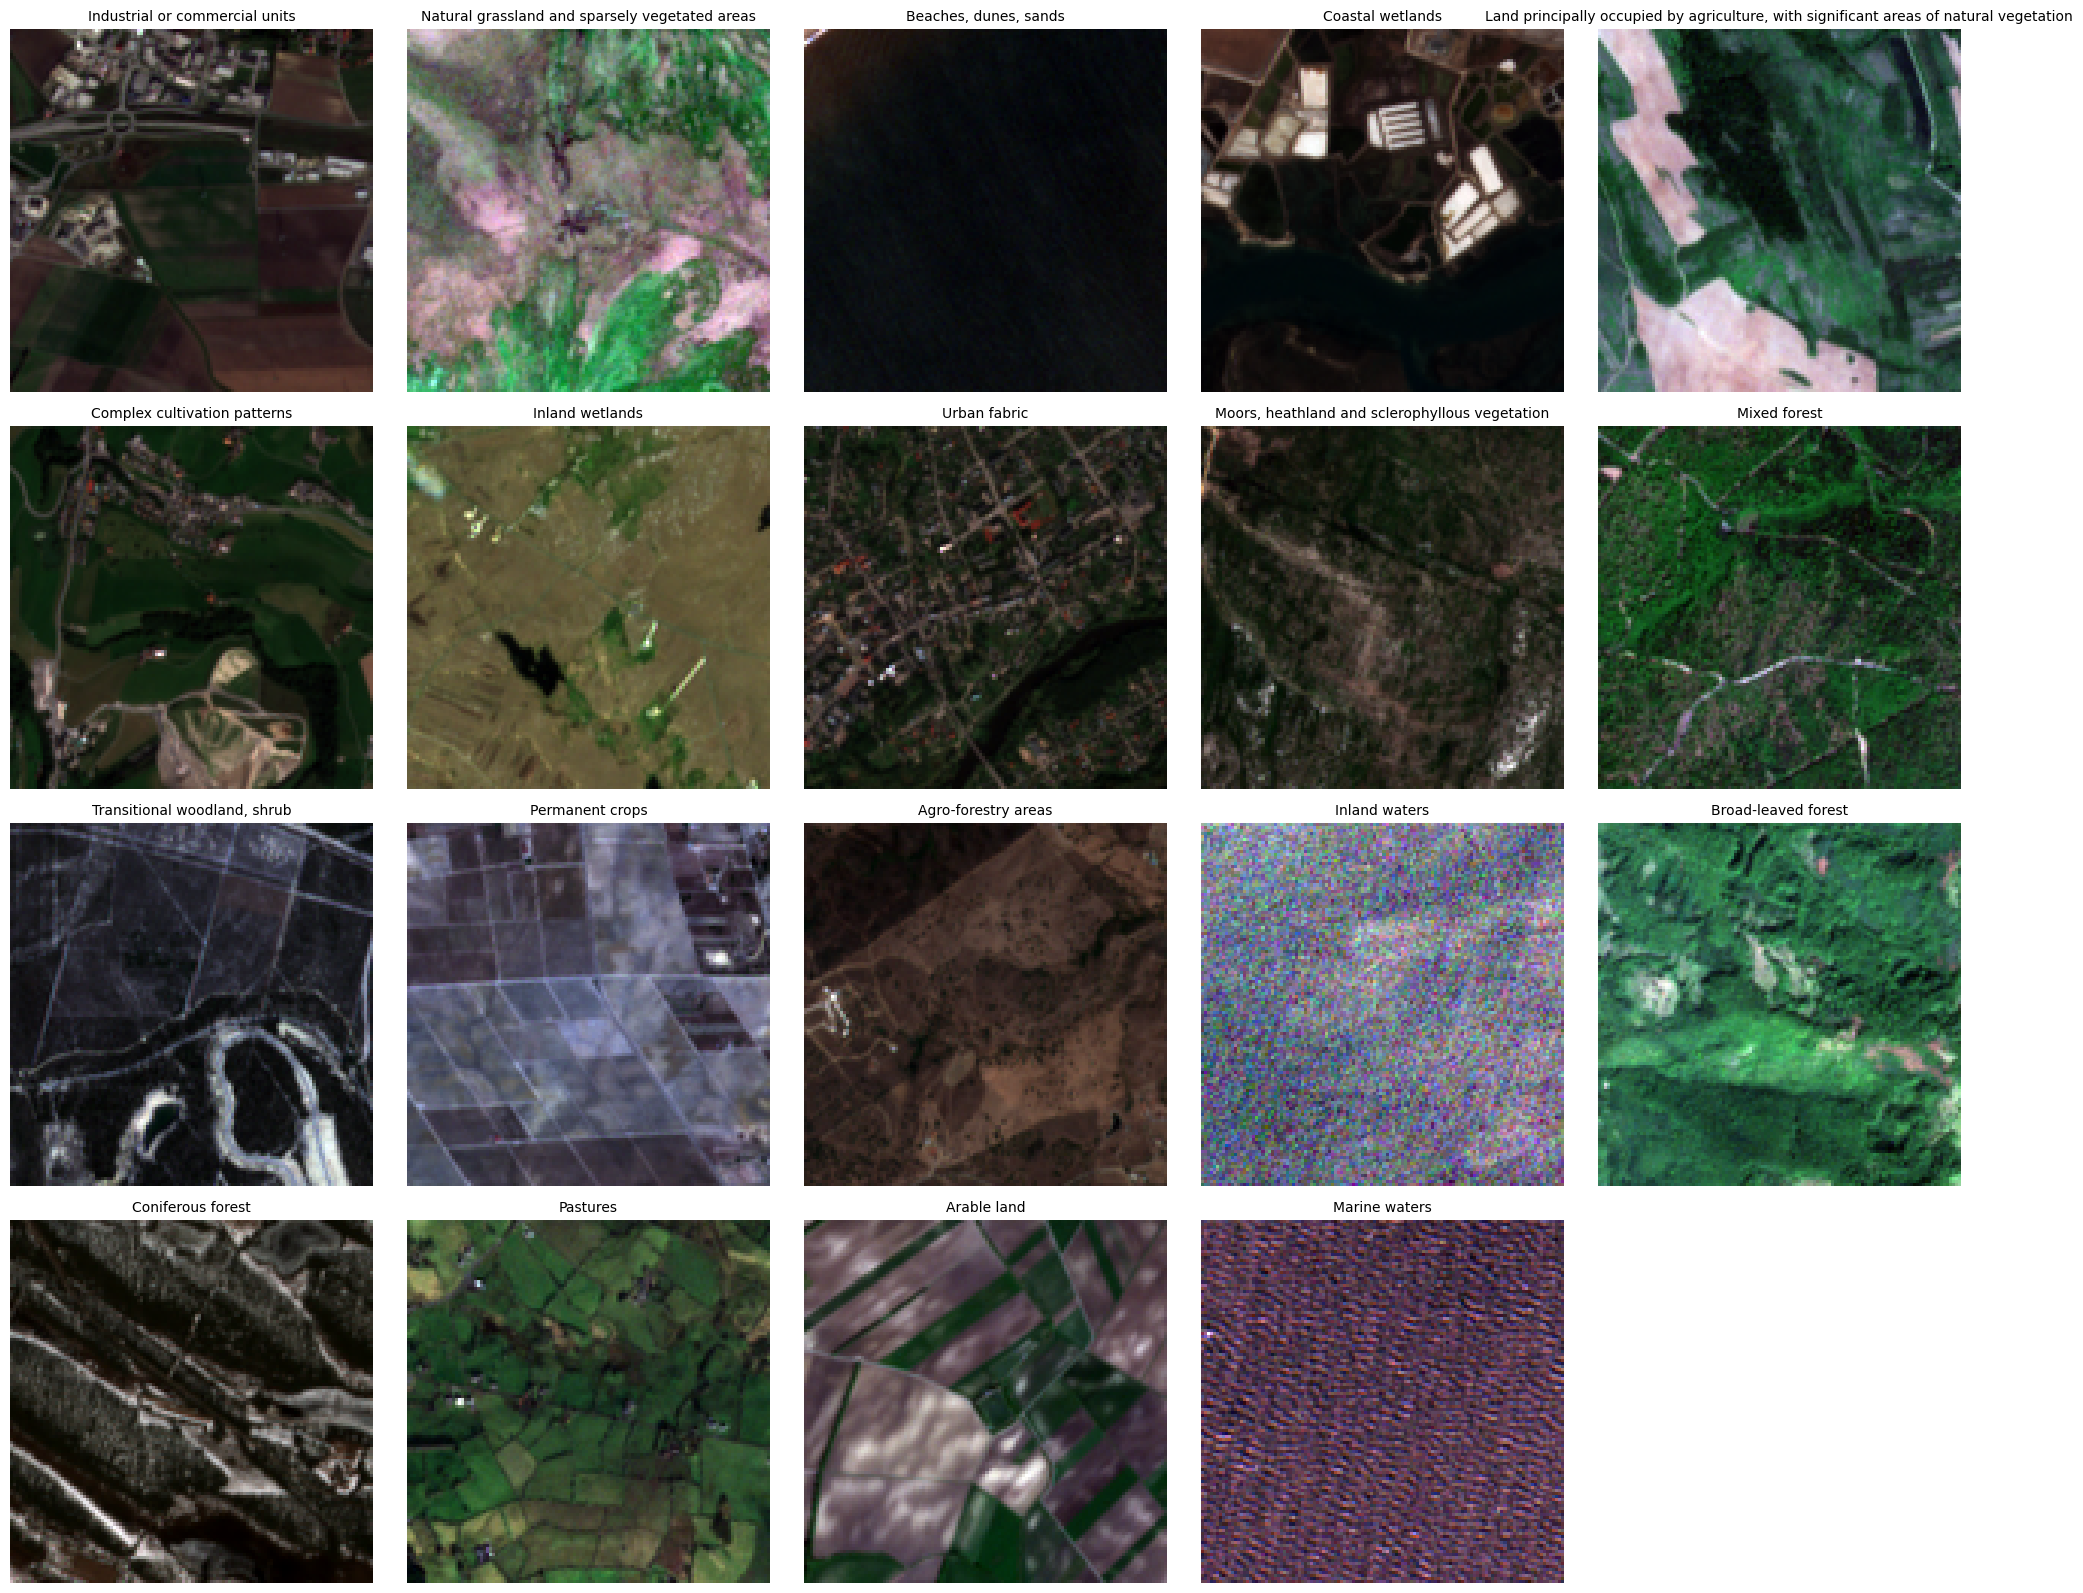

In [124]:
# Read the directory paths from the saved file
with open(r'C:\Users\isaac\Desktop\BigEarthTests\directory_paths.txt', 'r') as f:
    directory_paths = [line.strip() for line in f]

# List to store images and labels
images = []
image_labels = []

# Function to scale bands to the range [0, 255]
def scale_band(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)

# Create a mapping from patch_id to label
patch_id_to_label = {patch_id: label for label, patch_id in random_patch_ids.items()}
print(patch_id_to_label)

# Iterate through the directory paths and read the RGB bands
for dir_path in directory_paths:
    # Extract the last part of the path
    last_part = os.path.basename(dir_path)
    
    # Construct the paths for the RGB bands
    band_paths = {
        'B02': os.path.join(dir_path, f"{last_part}_B02.tif"),
        'B03': os.path.join(dir_path, f"{last_part}_B03.tif"),
        'B04': os.path.join(dir_path, f"{last_part}_B04.tif")
    }
    
    # Check if all band files exist
    if all(os.path.exists(band_path) for band_path in band_paths.values()):
        with rasterio.open(band_paths['B04']) as src_r, \
             rasterio.open(band_paths['B03']) as src_g, \
             rasterio.open(band_paths['B02']) as src_b:
            # Read the RGB bands
            r = scale_band(src_r.read(1))
            g = scale_band(src_g.read(1))
            b = scale_band(src_b.read(1))
            rgb = np.dstack((r, g, b))
            images.append(rgb)
            # Use the label instead of the patch_id for the title
            image_labels.append(patch_id_to_label.get(last_part, "Unknown"))
    else:
        print(f"Missing band files for {dir_path}")


# Plot the images
plt.figure(figsize=(20, 20))
for idx, (image, image_label) in enumerate(zip(images, image_labels), 1):
    plt.subplot(5, 5, idx)
    plt.imshow(image)
    plt.title(f"{image_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [201]:
def encode_label(label: list, num_classes=19):
    """This functions converts labels into multi-hot encoding"""

    target = torch.zeros(num_classes)
    for l in label:
        if l in reversed_labels:
            target[reversed_labels[l]] = 1
            
    return target

In [202]:
class BigEarthNetDataset(Dataset):
    """
    Parse raw data to form a Dataset of (X, y).
    """

    def __init__(self, *, df, root_dir, img_size, transforms=None, is_test=False):
        self.df = df
        self.root_dir = root_dir
        self.img_size = img_size
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        patch_id = row["patch_id"]

        # Remove the last two numbers from patch_id
        patch_id_base = "_".join(patch_id.split("_")[:-2])

        # Construct the paths for the RGB bands
        band_paths = {
            'B02': os.path.join(self.root_dir, patch_id_base, patch_id, f"{patch_id}_B02.tif"),
            'B03': os.path.join(self.root_dir, patch_id_base, patch_id, f"{patch_id}_B03.tif"),
            'B04': os.path.join(self.root_dir, patch_id_base, patch_id, f"{patch_id}_B04.tif")
        }

        # Load the RGB bands using rasterio
        with rasterio.open(band_paths['B02']) as b02:
            b02_img = b02.read(1)

        with rasterio.open(band_paths['B03']) as b03:
            b03_img = b03.read(1)
    
        with rasterio.open(band_paths['B04']) as b04:
            b04_img = b04.read(1)

        def normalize_band(band):
            band_min, band_max = band.min(), band.max()
            if band_max > band_min:
                normalized_band = ((band - band_min) / (band_max - band_min) * 255).astype('uint8')
            else:
                normalized_band = np.zeros(band.shape, dtype='uint8')
            return normalized_band
    
        # Normalize each band
        b02_img = normalize_band(b02_img)
        b03_img = normalize_band(b03_img)
        b04_img = normalize_band(b04_img)

        # Stack the images in the correct order: R, G, B
        img = np.dstack((b04_img, b03_img, b02_img))
        img = np.clip(img, 0, 255).astype('uint8')
        img = Image.fromarray(img)

        # Return the image and the binary vector as tensor
        return img, encode_label(row["labels"], num_classes=19)



In [203]:
class BigEarthNetModule(pl.LightningModule):
    def __init__(self, *, num_classes = 19, img_size=(120,120), batch_size=32, num_workers=0, pin_memory=False, shuffle_validation=False):
        super().__init__()
        self.num_classes = num_classes
        self.img_size = img_size
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.shuffle_validation = shuffle_validation

        # Define the transforms for the dataset
        # For training, apply data augmentation
        self.train_tfs = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # For validation and testing, only apply normalization
        self.valid_tfs = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.test_tfs = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    # Function to download the BigEarthNet dataset
    def download_dataset(self, url, save_path, chunk_size=1024):
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raise error for bad status
            total = int(response.headers.get('content-length', 0))
            block_size = chunk_size

            with open(save_path, 'wb') as file, tqdm(total=total, unit='iB', unit_scale=True, desc='Downloading BigEarthNet', unit_divisor=1024) as bar:
                for data in response.iter_content(block_size):
                    bar.update(len(data))
                    file.write(data)
            print(f"Downloaded dataset to: {save_path}")
        except requests.exceptions.RequestException as e:
            print(f"Error during dataset download: {e}")
            raise

    # Function to extract the BigEarthNet dataset
    def extract_tar_zsts(self, file_path, extract_path):
        with open(file_path, 'rb') as file_in:
            dctx = zstd.ZstdDecompressor()
            with open(file_path[:-4] + '.tar', 'wb') as file_out:
                dctx.copy_stream(file_in, file_out)
        print(f"Decompressed dataset to: {file_path[:-4] + '.tar'}")

    # Function to prepare the BigEarthNet dataset
    def prepare_data(self):
        dataset_url = 'https://zenodo.org/records/10891137/files/BigEarthNet-S2.tar.zst?download=1'
        dataset_path = 'D:\Datasets\BigEarthNet-S2.tar.zst'
        extract_path = 'D:\Datasets\BigEarthNet-S2'

        if os.path.exists(dataset_path) or os.path.exists(extract_path):
            print(f"Dataset already exists at: {dataset_path} or extracted at: {extract_path}")
            return
        else:
             self.download_dataset(dataset_url, dataset_path)

        if not os.path.exists(extract_path):
            self.extract_tar_zsts(dataset_path, extract_path)
        else:
            print(f"Extracted dataset already exists at: {extract_path}")

    def setup(self, stage=None):
        np.random.seed(42)

        # Load the metadata
        train_df = subset_metadata_df[subset_metadata_df['split'] == 'train'].reset_index(drop=True)
        test_df = subset_metadata_df[subset_metadata_df['split'] == 'test'].reset_index(drop=True)
        valid_df = subset_metadata_df[subset_metadata_df['split'] == 'validation'].reset_index(drop=True)

        # Initialize the datasets
        img_size = DatasetConfig.image_size
        common_img_dir = DatasetConfig.COMMON_IMG_DIR
        self.train_ds = BigEarthNetDataset(df=train_df, img_size=img_size, root_dir=common_img_dir, transforms=self.train_tfs)
        self.valid_ds = BigEarthNetDataset(df=valid_df, img_size=img_size, root_dir=common_img_dir, transforms=self.valid_tfs)
        self.test_ds = BigEarthNetDataset(df=test_df, img_size=img_size, root_dir=common_img_dir, transforms=self.test_tfs, is_test=True)

        print(f"Number of images - Training: {len(self.train_ds)}, Validation: {len(self.valid_ds)}, Testing: {len(self.test_ds)}\n")

    def train_dataloader(self):
        # Create a train dataloader.
        train_loader = DataLoader(self.train_ds, batch_size=self.batch_size, pin_memory=self.pin_memory, shuffle=True, num_workers=self.num_workers)
        return train_loader

    def val_dataloader(self):
        # Create a validation dataloader.
        valid_loader = DataLoader(self.valid_ds, batch_size=self.batch_size, pin_memory=self.pin_memory, shuffle=self.shuffle_validation, num_workers=self.num_workers)
        return valid_loader
            
    def test_dataloader(self):
        # Create a test dataloader.
        test_loader = DataLoader(self.test_ds, batch_size=self.batch_size, pin_memory=self.pin_memory, shuffle=False, num_workers=self.num_workers)
        return test_loader
    

In [204]:
%%time
# Initialize the BigEarthNet data module
dm = BigEarthNetModule(num_classes=DatasetConfig.num_classes, batch_size = 32, num_workers=0)
# Prepare the data
dm.prepare_data()
# Setup the data
dm.setup()

Dataset already exists at: D:\Datasets\BigEarthNet-S2.tar.zst or extracted at: D:\Datasets\BigEarthNet-S2
Number of images - Training: 2370, Validation: 1215, Testing: 1165

CPU times: total: 15.6 ms
Wall time: 8 ms


In [205]:
## Major bug here, need to fix

# Get a batch from the validation dataloader
valid_loader = dm.val_dataloader()

# Check the first item in the dataloader
first_item = next(iter(valid_loader))  # Get the first item directly
print(first_item)  # Should output a tuple (x, y)


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [129]:
subset_metadata_df.head(1)

,patch_id,labels,split,country,s1_name,s2v1_name,contains_seasonal_snow,contains_cloud_or_shadow,binary_vector,Arable land,...,Industrial or commercial units,Inland wetlands,"Transitional woodland, shrub",Natural grassland and sparsely vegetated areas,"Moors, heathland and sclerophyllous vegetation",Marine waters,Coastal wetlands,Permanent crops,"Beaches, dunes, sands",Agro-forestry areas
0,S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_2...,"[Arable land, Broad-leaved forest, Land princi...",test,Austria,S1B_IW_GRDH_1SDV_20170612T165809_33UUP_29_59,S2A_MSIL2A_20170613T101031_29_59,False,False,"[1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",1,...,0,0,0,0,0,0,0,0,0,0


In [130]:
# Flatten and count labels
all_labels = [label for labels_list in subset_metadata_df['labels'] for label in labels_list]
label_counts = Counter(all_labels)

# Convert counts from label names to their class IDs
label_counts_by_id = { reversed_labels[label]: count for label, count in label_counts.items()}

# Display results
counts_df = pd.DataFrame({
    'Label': [labels[i] for i in label_counts_by_id.keys()],
    'Count': list(label_counts_by_id.values())
})

# Sort the DataFrame by count in descending order
counts_df = counts_df.sort_values(by="Count", ascending=False)

# Display the DataFrame with a color gradient
counts_df.style.background_gradient(cmap="Blues")

,Label,Count
0,Arable land,1843
8,Mixed forest,1676
6,Coniferous forest,1562
11,"Transitional woodland, shrub",1410
1,Broad-leaved forest,1333
2,"Land principally occupied by agriculture, with significant areas of natural vegetation",1225
5,Complex cultivation patterns,1000
3,Pastures,921
4,Urban fabric,636
7,Inland waters,630


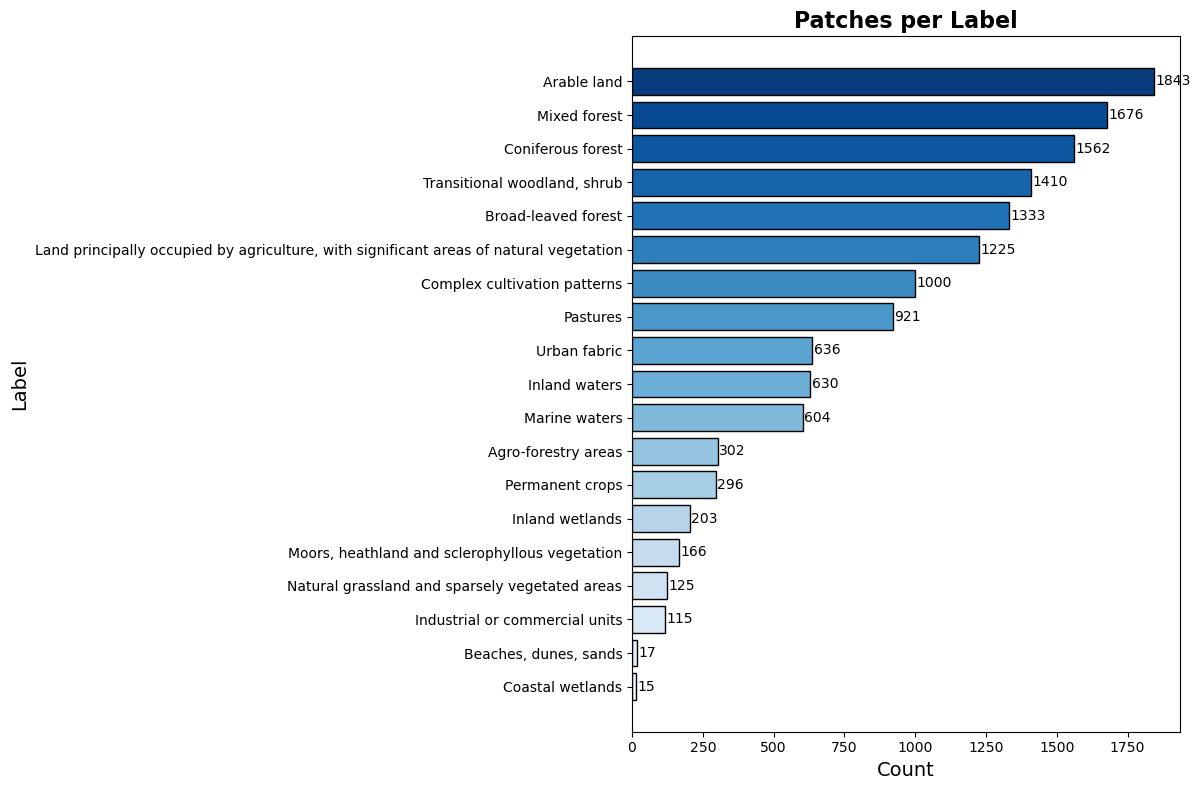

In [131]:
plt.figure(figsize=(12, 8))
# Use a color palette for better visuals
colors = sns.color_palette("Blues_r", len(counts_df))
# Create the horizontal bar plot
bars = plt.barh(counts_df['Label'], counts_df['Count'], color=colors, edgecolor='black')
# Invert y-axis to have the highest count on top
plt.gca().invert_yaxis()

# Add labels to each bar
for bar in bars:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center', ha='left', fontsize=10, color='black')

# Enhance plot appearance
plt.xlabel('Count', fontsize=14)
plt.ylabel('Label', fontsize=14)
plt.title('Patches per Label', fontsize=16, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()